<a href="https://colab.research.google.com/github/tony-wade/Qiskit/blob/main/Hybrid%20QNN/Hybrid_QNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Qiskit僅提供基礎0、1的圖案判別，這次想試試若拓展到0至9後的模型辨識結果。另外考量自身算力後決定試做FSL。

In [ ]:
import os
import numpy as np
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
import torch
from torch import no_grad
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
#!pip install qiskit
!pip install qiskit-machine-learning
from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
import random

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# 定義圖像變換
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, (0.1,0.1)),  # 随機平移最多10%的寬/高
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.85, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


class CustomMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_name).convert('L')  # 轉成黑白
        image = ImageOps.invert(img)
        label = int(self.image_files[idx].split('.')[0])  # 文件名=tag

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Training dataset
# -----------------------
# 設定批次大小、每類樣本數、數據增強之增生倍率
batch_size = 10
n_samples = 10
num_copies = 10

# 使用torchvision函數載入MNIST訓練數據，28*28
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
X_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# 選取每個數字類別的n_samples個樣本
idx = []
for digit in range(10):
    digit_indices = np.where(X_train.targets == digit)[0]
    selected_indices = random.sample(digit_indices.tolist(), n_samples)
    idx.extend(selected_indices)

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# 載入自己的手寫圖案共10張，並做數據增強
custom_dataset = CustomMNISTDataset('./selfmnist', transform=transform)
expanded_datasets = [custom_dataset] * num_copies

# 合併dataset
expanded_datasets.append(X_train)
expanded_dataset = ConcatDataset(expanded_datasets)

# 定義dataloader
train_loader = DataLoader(expanded_dataset, batch_size=batch_size, shuffle=True)




# Test dataset
# --------------------
# 測試集筆數
n_tests = 50

# 載入MNIST測試數據
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
)

# 選取每個數字類別的前n_tests個樣本
idx2 = []
for digit in range(10):
    idx2.extend(np.where(X_test.targets == digit)[0][:n_tests])
X_test.data = X_test.data[idx2]
X_test.targets = X_test.targets[idx2]

# 定義dataloader
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)


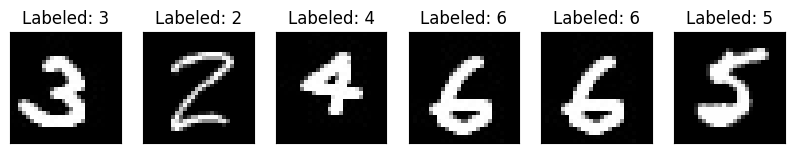

In [ ]:
n_samples_show = 6

data_iter = iter(train_loader) #轉成疊代器
fig, axes = plt.subplots(1, n_samples_show, figsize=(10, 3)) #控制子圖以[1,n]方式呈現

for ax in axes:
    images, targets = next(data_iter) #逐個讀取
    ax.imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    ax.set_xticks([]) #刻度不顯示
    ax.set_yticks([])
    ax.set_title("Labeled: {}".format(targets[0].item()))

In [ ]:
# 取最少須10個states, 取4qubits共2^4個states
def create_qnn():
    feature_map = EfficientSU2(4,reps=1)
    ansatz = RealAmplitudes(4, reps=1, parameter_prefix='A')
    qc = QuantumCircuit(4)
    qc.compose(feature_map, inplace=True) # 開啟可調參數
    qc.compose(ansatz, inplace=True)


    qnn = SamplerQNN(
        circuit = qc,
        input_params = feature_map.parameters,
        weight_params = ansatz.parameters,
        input_gradients = True,  # 要連接倒傳遞
    )
    return qnn

QNN = create_qnn()

In [ ]:
class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)  # 每5*5轉成1*1的Convolution Layer
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()   # 隨機丟失神經元避免overfitting
        self.fc1 = Linear(256, 16)
        # self.fc2 = Linear(64, 16)
        self.qnn = TorchConnector(qnn) # 沒指定,隨機權重in[-1,1].
        self.fc3 = Linear(16, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # width=28-5+1=24
        x = F.max_pool2d(x, 2)   # 分割成2*2小區域，輸出4者中的最大值，抗雜
        x = F.relu(self.conv2(x))  # 12-5+1
        x = F.max_pool2d(x, 2)   # 萃取後 width=4
        x = self.dropout(x)     # 16個4*4的圖
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        # x = self.fc2(x)
        x = self.qnn(x)
        x = self.fc3(x)
        return x


model = Net(QNN).to(device)

In [ ]:
lr = 0.001
b1 = 0.8
b2 = 0.85

optimizer = optim.NAdam(model.parameters(), lr=lr, betas=(b1, b2))
# optim.Adam(model.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
loss_func = CrossEntropyLoss()

# Start training
epochs = 300
loss_list = []
model.train()


for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)
        output = model(data.to(device))  # Forward pass
        loss = loss_func(output, target.to(device))
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss) / len(total_loss))  #每epoch平均loss
    if epoch % 10 == 0:
      print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [0%]	Loss: 2.2469
Training [4%]	Loss: 2.0935
Training [7%]	Loss: 1.9602
Training [10%]	Loss: 1.8120
Training [14%]	Loss: 1.6758
Training [17%]	Loss: 1.5401
Training [20%]	Loss: 1.4154
Training [24%]	Loss: 1.2939
Training [27%]	Loss: 1.1707
Training [30%]	Loss: 1.0982
Training [34%]	Loss: 0.9950
Training [37%]	Loss: 0.9269
Training [40%]	Loss: 0.8618
Training [44%]	Loss: 0.8162
Training [47%]	Loss: 0.7305
Training [50%]	Loss: 0.6896
Training [54%]	Loss: 0.6057
Training [57%]	Loss: 0.6041
Training [60%]	Loss: 0.5715
Training [64%]	Loss: 0.5499
Training [67%]	Loss: 0.5054
Training [70%]	Loss: 0.4637
Training [74%]	Loss: 0.4474
Training [77%]	Loss: 0.4396
Training [80%]	Loss: 0.4199
Training [84%]	Loss: 0.3970
Training [87%]	Loss: 0.3794
Training [90%]	Loss: 0.3519
Training [94%]	Loss: 0.3225
Training [97%]	Loss: 0.3280


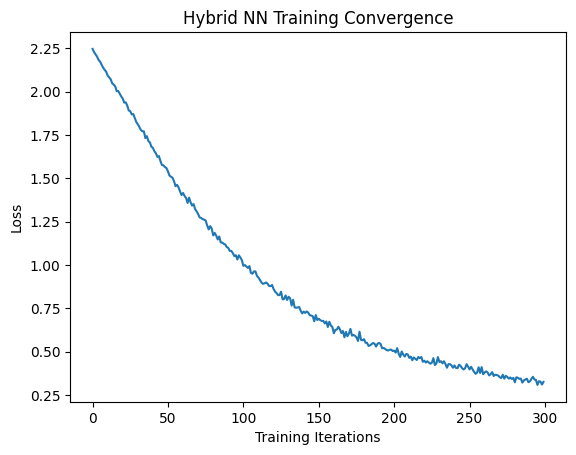

In [ ]:
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Loss")
plt.show()

In [ ]:
torch.save(model.state_dict(), "model.pt")

能複製這段並額外做成一個 testing program


In [ ]:
QNN_test = create_qnn()
model_test = Net(QNN_test)
model_test.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

Performance on test data:
	Loss: 0.9907
	Accuracy: 21.0%


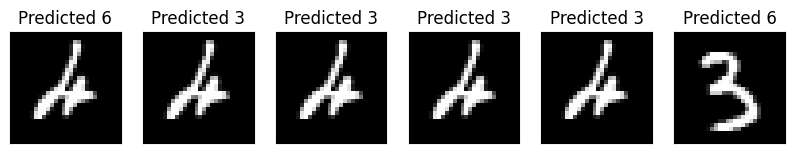

In [ ]:
loss_func = CrossEntropyLoss()
total_loss = []
correct = 0
n_samples_show = 6
i = 0    # 當下張數
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_test.eval()  # evaluation mode
with no_grad():   # 因為純評估效能，不計算grad

    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_test(data)
        pred = output.argmax(dim=1)  # 取0~9最可能
        total_loss.append(loss_func(output, target).item())

        for j in range(len(target)):

            if pred[j] == target[j]:
                correct += 1
            elif i == n_samples_show:
                break
            else:
                axes[i].imshow(data[0].numpy().squeeze(), cmap="gray")
                axes[i].set_xticks([])
                axes[i].set_yticks([])
                axes[i].set_title("Predicted {}".format(pred[j].item()))
                i += 1

    accuracy = correct / len(test_loader) / batch_size  * 100
    avg_loss = sum(total_loss) / len(total_loss)

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            avg_loss, accuracy
        )
    )

plt.show()

可以看到以QNN做FSL並不是一個好選擇。畢竟構造等同最陽春的NN，泛化能力掛勾於training data，但仍是不錯的嘗試。



這段為載入自己的手寫圖(小畫家etc.)做評估的code

In [ ]:
def preprocess_input_image(image):
    # Define transformations
    preprocess = transforms.Compose([
        transforms.Resize((28, 28)),    # Resize to 28x28
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Apply transformations
    preprocessed_image = preprocess(image).unsqueeze(0)    # 轉換成(1, 通道數, H, W)輸出
    return preprocessed_image

In [ ]:
model_test.eval()
with torch.no_grad():

    img = Image.open('2.jpg')
    img = preprocess_input_image(img)
    output = model_test(img)
    predicted_class = output.argmax(dim=1).item()

    print("Predicted class:", predicted_class)

Predicted class: 2
